In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from utils import normalize_rgb

In [2]:
cap = cv.VideoCapture(0)


face_cascade = cv.CascadeClassifier(cv.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    _, frame = cap.read()
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    norm_rgb = normalize_rgb(rgb)

    faces = face_cascade.detectMultiScale(gray)
    
    if len(faces) == 0:
        continue
    else:
        for (x, y, w, h) in faces:
            face_region = rgb[y:y+h, x:x+w]

            outer_region = rgb[y-40:y+h+40, x-40:x+w+40]
            inner_region = rgb[y+25:y+h-25, x+25:x+w-25]
        break



cap.release()
cv.destroyAllWindows()

Text(0.5, 1.0, 'inner face region')

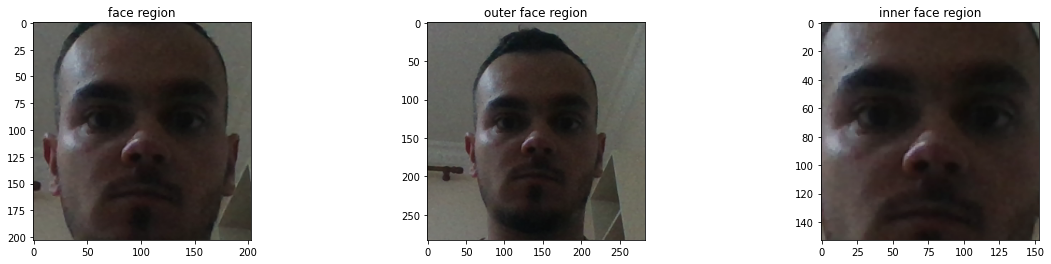

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
axes[0].imshow(face_region)
axes[0].set_title('face region')
axes[1].imshow(outer_region)
axes[1].set_title('outer face region')
axes[2].imshow(inner_region)
axes[2].set_title('inner face region')

In [4]:
x, y, _ = inner_region.shape
n = x * y

norm_inner = normalize_rgb(inner_region)

r = norm_inner[:,:,0]
g = norm_inner[:,:,1]
R = inner_region[:,:,0]

In [5]:
def plot_histograms(src, show_lines=False):
    norm_src = normalize_rgb(src)
    hist_r = cv.calcHist([norm_src], [0], None, [256], [0, 256])
    hist_g = cv.calcHist([norm_src], [1], None, [256], [0, 256])
    hist_R = cv.calcHist([src], [0], None, [256], [0, 256])

    r = norm_src[:,:,0]
    g = norm_src[:,:,1]
    R = src[:,:,0]

    fig, axes = plt.subplots(1, 3, figsize=(20, 4))
    
    axes[0].hist(r.ravel(), 256, [0, 256], color='r')
    axes[0].set_title('r')
    axes[1].hist(g.ravel(), 256, [0, 256], color='g')
    axes[1].set_title('g')
    axes[2].hist(R.ravel(), 256, [0, 256], color='r')
    axes[2].set_title('R')

    if show_lines:
        axes[0].vlines([L_r, mu_r, U_r], 0, np.max(hist_r), ['b', 'k', 'b'], linestyles='dashed')
        axes[1].vlines([L_g, mu_g, U_g], 0, np.max(hist_g), ['b', 'k', 'b'], linestyles='dashed')
        axes[2].vlines([L_R, mu_R, U_R], 0, np.max(hist_R), ['b', 'k', 'b'], linestyles='dashed')

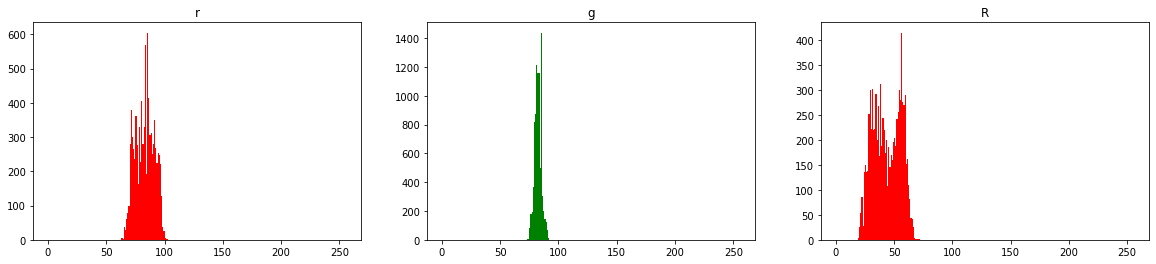

In [6]:
plot_histograms(inner_region)

In [7]:
# calculate the mean and standart deviation for each component
mu_r = 1/n * np.sum(r)
mu_g = 1/n * np.sum(g)
mu_R = 1/n * np.sum(R)

sigma_r = np.sqrt(1/n * np.sum((r-mu_r)**2))
sigma_g = np.sqrt(1/n * np.sum((g-mu_g)**2))
sigma_R = np.sqrt(1/n * np.sum((R-mu_R)**2))

U_r, L_r = mu_r + 2*sigma_r, mu_r - 2*sigma_r
U_g, L_g= mu_g + 2*sigma_g, mu_g - 2*sigma_g
U_R, L_R = mu_R + 2*sigma_R, mu_R - 2*sigma_R

In [8]:
print('mu_r =', mu_r, '\t sigma_r =', sigma_r)
print('mu_g =', mu_g, '\t sigma_g =', sigma_g)
print('mu_R =', mu_R, '\t sigma_R =', sigma_R)

mu_r = 82.5915572657311 	 sigma_r = 8.05178555261722
mu_g = 82.18028519692169 	 sigma_g = 2.9362435560008646
mu_R = 43.423947487550926 	 sigma_R = 11.752887457703313


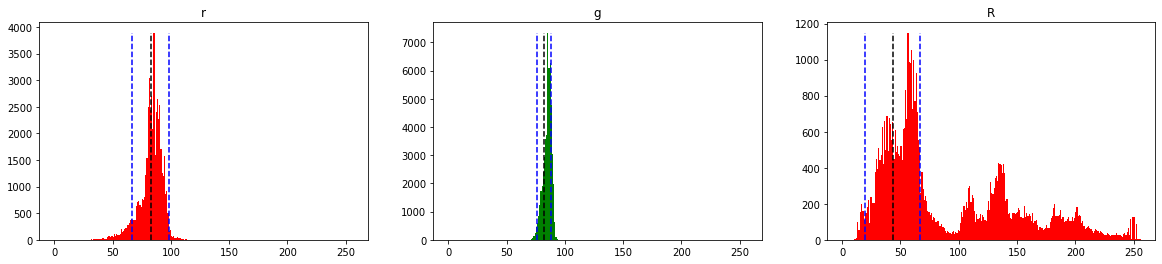

In [9]:
plot_histograms(outer_region, show_lines=True)

In [10]:
def calculate_adaptive_skin_mask(src):
    rgb = cv.cvtColor(src, cv.COLOR_BGR2RGB)
    norm_rgb = normalize_rgb(rgb)
    r = norm_rgb[:, :, 0]
    g = norm_rgb[:, :, 1]
    R = rgb[:, :, 0]

    _, t1 = cv.threshold(r - L_r, 0, 255, cv.THRESH_BINARY)
    _, t2 = cv.threshold(U_r - r, 0, 255, cv.THRESH_BINARY)
    _, t3 = cv.threshold(g - L_g, 0, 255, cv.THRESH_BINARY)
    _, t4 = cv.threshold(U_g - g, 0, 255, cv.THRESH_BINARY)
    _, t5 = cv.threshold(R - L_R, 0, 255, cv.THRESH_BINARY)
    _, t6 = cv.threshold(U_R - R, 0, 255, cv.THRESH_BINARY)

    t = cv.bitwise_and(t1, t2)
    t = cv.bitwise_and(t, t3)
    t = cv.bitwise_and(t, t4)
    t = cv.bitwise_and(t, t5)
    t = cv.bitwise_and(t, t6)

    return t

In [11]:
cap = cv.VideoCapture(0)

while True:
    _, frame = cap.read()
    skin_mask = calculate_adaptive_skin_mask(frame)
    
    cv.imshow('face', frame)
    cv.imshow('mask', skin_mask)

    if cv.waitKey(1) == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

Text(0.5, 1.0, 'adaptive skin mask')

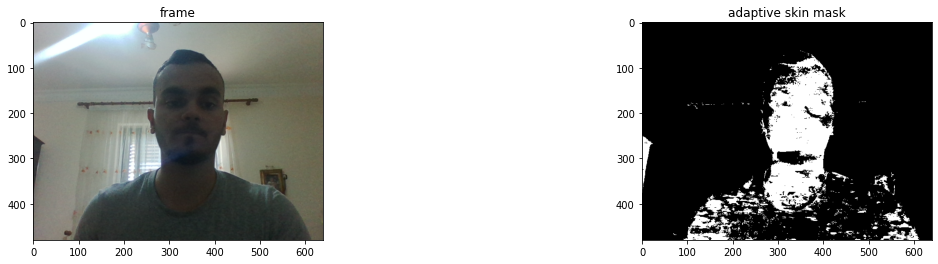

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
axes[0].imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
axes[0].set_title('frame')
axes[1].imshow(skin_mask, cmap='gray')
axes[1].set_title('adaptive skin mask')